<a href="https://colab.research.google.com/github/ahvan77/DMA/blob/main/Copy_of_Fahir_circuit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This an attempt to recreate the Fahir circuit explained [here](https://docs.google.com/presentation/d/1-GqSrNQ9x2QCrOr0nt7p6WXpmcACZ6K8Q-w-3Vcv384/edit?usp=sharing).



# Using CIRQ

In [ ]:
!python -m pip install -q cirq
#!sudo apt-get install texlive-latex-base latexmk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.8/598.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 697.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.5/596.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.8/223.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 19.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
import cirq
import sympy
from cirq.contrib.svg import SVGCircuit

https://quantumai.google/reference/python/cirq/XXPowGate

In [ ]:
help(cirq.XX)

Help on XXPowGate in module cirq.ops.parity_gates:

cirq.XX
    The tensor product of two X gates.
    
    Useful for creating `cirq.XXPowGate`s via `cirq.XX**t`.
    
    This is the `exponent=1` instance of `cirq.XXPowGate`.



In [ ]:
help(cirq.ZZ)

Help on ZZPowGate in module cirq.ops.parity_gates:

cirq.ZZ
    The tensor product of two Z gates.
    
    Useful for creating `cirq.ZZPowGate`s via `cirq.ZZ**t`.
    
    This is the `exponent=1` instance of `cirq.ZZPowGate`.



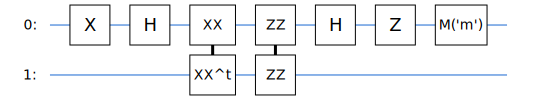

In [ ]:
# Create a circuit to generate a Bell State:
fahir_circuit = cirq.Circuit()
readout, q1 = cirq.LineQubit.range(2)
fahir_circuit.append(cirq.X(readout))
fahir_circuit.append(cirq.H(readout))
fahir_circuit.append(cirq.XX(q1, readout) ** sympy.Symbol('t')) # t is a trainable parameter
fahir_circuit.append(cirq.ZZ(q1, readout))
fahir_circuit.append(cirq.H(readout))
fahir_circuit.append(cirq.Z(readout))
# For sampling, we need to add a measurement at the end
fahir_circuit.append(cirq.measure(readout, key='m'))
SVGCircuit(fahir_circuit)


0: ───X───H───XX─────ZZ───H───Z───M('m')───
              │      │
1: ───────────XX^t───ZZ────────────────────
Simulate the circuit:


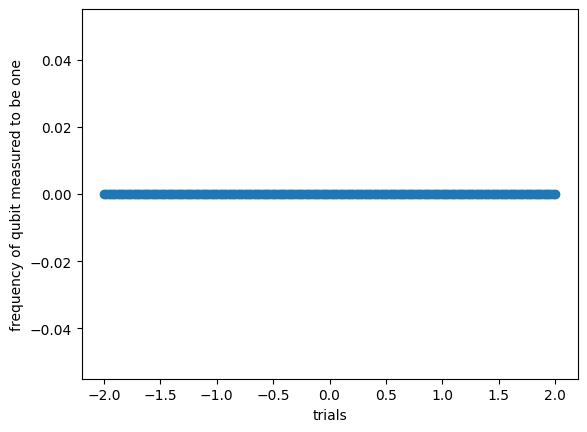

In [ ]:
# Initialize Simulator
import matplotlib.pyplot as plt
s = cirq.Simulator()
print(fahir_circuit)
print('Simulate the circuit:')

# Sweep exponent
param_sweep = cirq.Linspace('t', start=-2, stop=2, length=200)
trials = s.run_sweep(fahir_circuit, param_sweep, repetitions=1000)

# Plot all the results
x_data = [trial.params['t'] for trial in trials]
y_data = [trial.histogram(key='m')[1] / 1000.0 for trial in trials]
plt.scatter('t', 'p', data={'t': x_data, 'p': y_data})
plt.xlabel("trials")
plt.ylabel("frequency of qubit measured to be one")
plt.show()

https://github.com/sfoucher/sirfqc/blob/main/quantum/fvqc.py#L16

In [ ]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)



In [ ]:
observable= 'x'
data_qubits = cirq.GridQubit.rect(4, 4) # A list of GridQubits filling in a rectangular grid
readout = cirq.GridQubit(-1, -1) # A qubit on a 2d square lattice.
circuit = cirq.Circuit()

# Prepare the readout qubit
circuit.append(cirq.X(readout))
circuit.append(cirq.H(readout))

builder = CircuitLayerBuilder(
    data_qubits=data_qubits,
    readout=readout)

# Add layers
builder.add_layer(circuit, cirq.XX, "xx1")
builder.add_layer(circuit, cirq.ZZ, "zz1")

# Prepare measurement
if observable == 'x':
    circuit.append(cirq.H(readout))

if observable == 'y':
    s_dg = cirq.ops.ZPowGate(exponent=-(1 / 2))
    circuit.append(s_dg(readout))
    circuit.append(cirq.H(readout))
circuit.append(cirq.Z(readout))

print(circuit)

(-1, -1): ───X───H───XX───────────XX───────────XX───────────XX───────────XX───────────XX───────────XX───────────XX───────────XX───────────XX───────────XX────────────XX────────────XX────────────XX────────────XX────────────XX────────────ZZ───────────ZZ───────────ZZ───────────ZZ───────────ZZ───────────ZZ───────────ZZ───────────ZZ───────────ZZ───────────ZZ───────────ZZ────────────ZZ────────────ZZ────────────ZZ────────────ZZ────────────ZZ────────────H───Z───
                     │            │            │            │            │            │            │            │            │            │            │             │             │             │             │             │             │            │            │            │            │            │            │            │            │            │            │             │             │             │             │             │
(0, 0): ─────────────XX^(xx1-0)───┼────────────┼────────────┼────────────┼────────────┼────────────┼─────

# Using Qiskit

In [ ]:
import os
!pip install -q pylatexenc
os._exit(00) # we restart the kernel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip uninstall -y pydantic
!pip install -q pydantic==1.10.15 # to solve a problem with the last version
!pip install -q qiskit-ibm-runtime==0.20.0

Found existing installation: pydantic 2.7.1
Uninstalling pydantic-2.7.1:
  Successfully uninstalled pydantic-2.7.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 32.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49

In [ ]:
!pip install -q qiskit-algorithms qiskit-aer qiskit_machine_learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Copy your token: https://quantum.ibm.com/account

https://github.com/Qiskit/qiskit-ibm-runtime?tab=readme-ov-file#qiskit-runtime-service-on-ibm-cloud

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
from google.colab import userdata
# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token=userdata.get('QIKSKIT_API_KEY'))


Fahri circuit with 1 data qubit:

In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import RXXGate, RZZGate
from qiskit.circuit import ParameterVector

theta = ParameterVector("th", 2)

c_r = ClassicalRegister(1, name='cbit')
q_r = QuantumRegister(1, name='register')
q_d = QuantumRegister(1, name='qd')

circuit = QuantumCircuit(c_r, q_r, q_d)
# Build a quantum circuit

circuit.x(1)
circuit.h(1)
circuit.append(RXXGate(theta=theta[0]), [0, 1])
circuit.append(RZZGate(theta=theta[1]), [0, 1])
circuit.h(0)
circuit.measure(q_r, c_r)
#circuit.measure(range(3), range(3))
print(circuit)

                    ┌─────────────┐            ┌───┐┌─┐
register: ──────────┤0            ├─■──────────┤ H ├┤M├
          ┌───┐┌───┐│  Rxx(th[0]) │ │ZZ(th[1]) └───┘└╥┘
      qd: ┤ X ├┤ H ├┤1            ├─■────────────────╫─
          └───┘└───┘└─────────────┘                  ║ 
  cbit: 1/═══════════════════════════════════════════╩═
                                                     0 


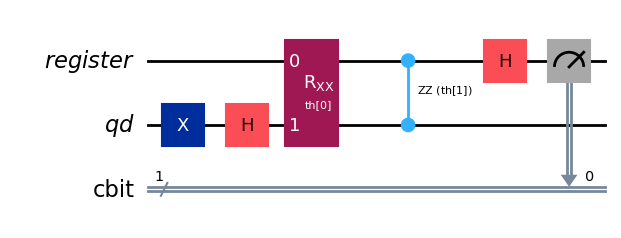

In [ ]:
# Matplotlib Drawing
circuit.draw(output='mpl')

# Training

Example taken from: https://github.com/Qiskit/textbook/blob/main/notebooks/ch-applications/machine-learning-qiskit-pytorch.ipynb

🔖 __ — via [Quantum Neural Networks - Qiskit Machine Learning 0.7.2](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/01_neural_networks.html#2.-How-to-Instantiate-QNNs)

🔖 _hybrid quantum-classical_ — via [Torch Connector and Hybrid QNNs - Qiskit Machine Learning 0.7.2](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/05_torch_connector.html#)

Image features have been pre-computed here: https://github.com/sfoucher/sirfqc/tree/main/features


In [ ]:
!wget https://github.com/sfoucher/sirfqc/raw/main/features/dae-eurosat-AnnualCropvsSeaLake-data.npz

--2024-05-08 17:49:24--  https://github.com/sfoucher/sirfqc/raw/main/features/dae-eurosat-AnnualCropvsSeaLake-data.npz
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sfoucher/sirfqc/main/features/dae-eurosat-AnnualCropvsSeaLake-data.npz [following]
--2024-05-08 17:49:24--  https://raw.githubusercontent.com/sfoucher/sirfqc/main/features/dae-eurosat-AnnualCropvsSeaLake-data.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 433522 (423K) [application/octet-stream]
Saving to: ‘dae-eurosat-AnnualCropvsSeaLake-data.npz.1’

dae-eurosat-AnnualC 100%[===================>] 423.36K  --.-KB/s    in 0

In [ ]:
import numpy as np
enc_x_train_u, enc_x_val_u, enc_x_test_u, y_train, y_val, y_test= np.load('dae-eurosat-AnnualCropvsSeaLake-data.npz').values()
print(enc_x_train_u.shape)
print(enc_x_val_u.shape)
print(enc_x_test_u.shape)

(4200, 4, 4)
(900, 4, 4)
(900, 4, 4)


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size= 64
n_qubits= 4

labels= torch.ones(enc_x_train_u.shape[0],1) # pseudo labels
train_dataset = TensorDataset(torch.tensor(enc_x_train_u.reshape(enc_x_train_u.shape[0],-1)[...,:n_qubits]), torch.tensor(y_train[..., np.newaxis], dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(torch.tensor(enc_x_val_u.reshape(enc_x_val_u.shape[0],-1)[...,:n_qubits]), torch.tensor(y_val[..., np.newaxis], dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Rotation encoding:

🔖 __ — via [RYGate | IBM Quantum Documentation](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RYGate)

\begin{align}
RY(\theta) = \exp\left(-i \frac{\theta}{2} Y\right) =
\begin{pmatrix}
\cos\left(\frac{\theta}{2}\right) & -\sin\left(\frac{\theta}{2}\right) \\
\sin\left(\frac{\theta}{2}\right) & \cos\left(\frac{\theta}{2}\right)
\end{pmatrix}
\end{align}

In [ ]:
RYGate?

R_ZZ orresponds to a rotation of the qubit state around the Z-axis by the given angle theta θ on the Bloch Sphere

\begin{align}
R_{ZZ}(\theta) = \exp\left(-i \frac{\theta}{2} Z{\otimes}Z\right) =
\begin{pmatrix}
    e^{-i \frac{\theta}{2}} & 0 & 0 & 0 \\
    0 & e^{i \frac{\theta}{2}} & 0 & 0 \\
    0 & 0 & e^{i \frac{\theta}{2}} & 0 \\
    0 & 0 & 0 & e^{-i \frac{\theta}{2}}
\end{pmatrix}
\end{align}

In [ ]:
RZZGate?

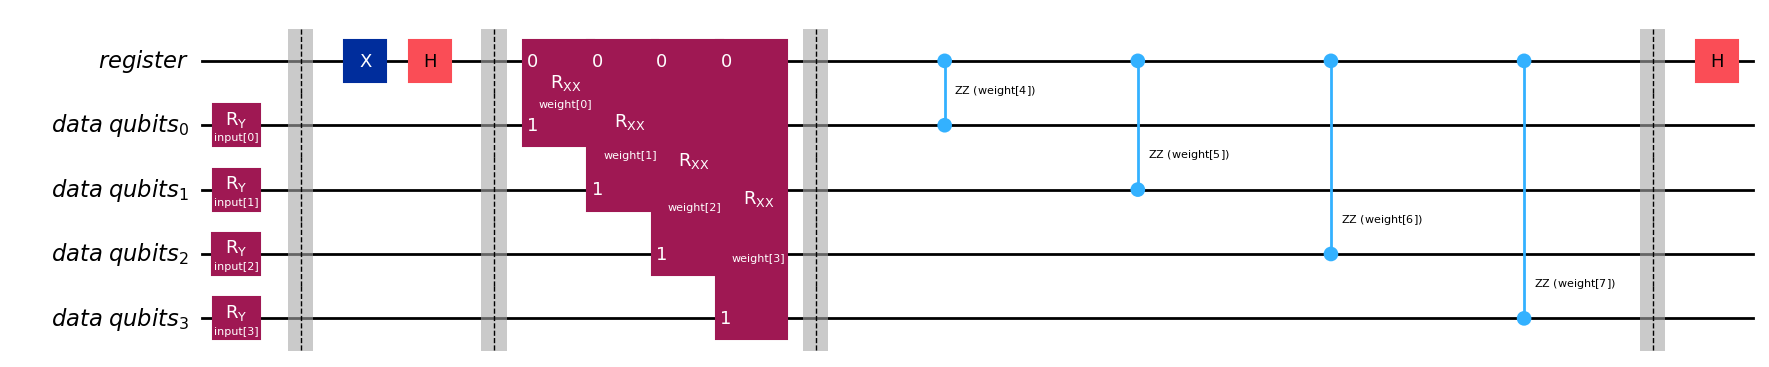

In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import RXXGate, RZZGate, RYGate, RealAmplitudes
from qiskit.circuit import ParameterVector

inputs = ParameterVector("input", n_qubits)
weights = ParameterVector("weight", 2*n_qubits)

c_r = ClassicalRegister(1, name='cbit')
q_r = QuantumRegister(1, name='register')
q_d = QuantumRegister(n_qubits, name='data qubits')


#circuit = QuantumCircuit(c_r, q_r, q_d)
circuit = QuantumCircuit(q_r, q_d)
#encoder = RealAmplitudes(n_qubits, reps=0)

for i in range(n_qubits):
    circuit.ry(theta=inputs[i],qubit=i+1)
circuit.barrier()
circuit.x(q_r)
circuit.h(q_r)
circuit.barrier()
for i in range(n_qubits):
    circuit.append(RXXGate(theta=weights[i]), [0, i+1])
circuit.barrier()
for i in range(n_qubits):
    circuit.append(RZZGate(theta=weights[i+n_qubits]), [0, i+1])
circuit.barrier()
circuit.h(q_r)

circuit.draw(output="mpl")

In [ ]:
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

observable1 = SparsePauliOp.from_list([("IIIIZ", 0)]) # the measurement (big endian notation)

# Set seed for random generators
algorithm_globals.random_seed = 42

# Setup QNN
Fahir_circuit = EstimatorQNN(
    circuit=circuit,
    observables= observable1,
    input_params=inputs,
    weight_params=weights,
    input_gradients=True,
)

# Set up PyTorch module
# Note: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(Fahir_circuit.num_weights) - 1)
model_fahir = TorchConnector(Fahir_circuit, initial_weights=initial_weights)
print("Initial weights: ", initial_weights)
print(Fahir_circuit.observables)

Initial weights:  [ 0.05479121 -0.01222431  0.07171958  0.03947361 -0.08116453  0.09512447
  0.05222794  0.05721286]
(SparsePauliOp(['IIIIZ'],
              coeffs=[0.+0.j]),)


You can also wrap the circuit inside a classical neural net:

```python
from torch.nn import Linear, Module
from torch import cat, no_grad, manual_seed

class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.qnn = qnn  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)


model_fahir_net = Net(qnn = model_fahir)
```



Let's test the forward method

In [ ]:
import torch
model_fahir(torch.rand(1, 4))

tensor([[0.]], grad_fn=<_TorchNNFunctionBackward>)

Optimizer:

In [ ]:
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss, BCELoss
from torch.optim import Adam
device= 'cuda'
device= 'cpu'
model_fahir.to(device)
# Define optimizer and loss
optimizer = Adam(model_fahir.parameters())
f_loss = BCELoss(reduction="sum")


Training loop:

In [ ]:
# prompt: how to add a tqdm bar on the train_loader

from tqdm import tqdm
for epoch in range(10):
    model_fahir.train()
    for i, (x, y) in enumerate(tqdm(train_loader)):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model_fahir(x)
        loss = f_loss(y_pred, y)
        loss.backward()
        optimizer.step()

    model_fahir.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model_fahir(x)
            loss = f_loss(y_pred, y)
            print(f"Epoch: {epoch+1:02d}, Loss: {loss:.5f}")



In [ ]:
# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
from tqdm import tqdm

model_fahir.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    #for batch_idx, (data, target) in enumerate(train_loader):
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # Initialize gradient
        output = model_fahir(data)  # Forward pass
        loss = f_loss(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

 20%|█▉        | 13/66 [01:16<05:11,  5.88s/it]